In [30]:
import cv2
#globbing utility.
import glob
import os
import numpy as np
from tqdm import tqdm
#select the path
#I have provided my path from my local computer, please change it accordingly

# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
import random

# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
import tensorflow as tf

%matplotlib inline


In [31]:
d = './CropCset'
lst = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]

lst

['./SampleSet/Harsh', './SampleSet/Abhishek Akkewar', './SampleSet/Rishab']

In [32]:
src = []
tgt = []
P = []
for path in tqdm(lst):
    path1 = path +"/side/*.jpg"
    folder = path.split('/')[-1]
    tgtpath = path+"/"+folder+"_01.jpg"
    #print(tgtpath)
    for file in glob.glob(path1):
        #print (file)
        a= cv2.imread(file)
        a= cv2.resize(a, (256,256), interpolation = cv2.INTER_AREA)
        src.append(a)
        b= cv2.imread(tgtpath)
        b= cv2.resize(b, (256,256), interpolation = cv2.INTER_AREA)
        tgt.append(b)
        #file = file.split('/')
        #file = (file[len(file) - 1])
        #file = file.split('_')
        #ylabel = (file[0])
        #pose_label = (file[len(file) - 1]).split('.')[0]
        #if pose_label in ['01','02','04','05']:
            #path2 = path+"/"+ylabel+"_03.jpg"
        #elif pose_label in ['066','07','09','10']:
            #path2 = path+"/"+ylabel+"_08.jpg"
        #print(path2)
        #print('___________________________')
        #b= cv2.imread(path2)
        #b= cv2.resize(b, (256,256), interpolation = cv2.INTER_AREA)
        #src.append(a)
        #tgt.append(b)
        

    



print(folder)
print(tgtpath)
print(path1)

100%|██████████| 3/3 [00:00<00:00, 70.27it/s]

Rishab
./SampleSet/Rishab/Rishab_01.jpg
./SampleSet/Rishab/side/*.jpg


In [33]:
src = np.asarray(src)
tgt = np.asarray(tgt)

print(src.shape)
print(tgt.shape)

(16, 256, 256, 3)
(16, 256, 256, 3)


In [34]:
filename = 'cfaces_256.npz'
savez_compressed(filename, src, tgt)
print('Saved dataset: ', filename)

Saved dataset:  sfaces_256.npz


In [35]:
data = load('cfaces_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']


Loaded:  (16, 256, 256, 3) (16, 256, 256, 3)


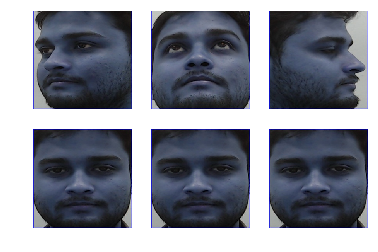

In [37]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('cfaces_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
r = random.randint(1,len(src_images)-3)
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[r+i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[r+i].astype('uint8'))
pyplot.show()

In [38]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [39]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [40]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [41]:
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [42]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [43]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [44]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'smodel/plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'smodel/model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [45]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo) == 0:
			summarize_performance(i, g_model, dataset)

In [46]:
# load image data
dataset = load_real_samples('cfaces_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)


Loaded (16, 256, 256, 3) (16, 256, 256, 3)


In [28]:
dataset[0].shape[1:]

(256, 256, 3)

In [47]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

>1, d1[0.451] d2[0.852] g[54.796]
>2, d1[0.344] d2[0.626] g[52.102]
>3, d1[0.436] d2[0.591] g[49.113]
>4, d1[0.393] d2[0.400] g[47.168]
>5, d1[0.545] d2[0.548] g[37.407]
>6, d1[0.456] d2[0.535] g[35.464]
>7, d1[0.522] d2[0.591] g[41.470]
>8, d1[0.449] d2[0.361] g[39.657]
>9, d1[0.290] d2[0.331] g[37.019]
>10, d1[0.221] d2[0.439] g[34.611]
>11, d1[0.207] d2[0.342] g[32.164]
>12, d1[0.264] d2[0.226] g[29.056]
>13, d1[0.499] d2[0.216] g[32.571]
>14, d1[0.324] d2[0.285] g[31.712]
>15, d1[0.303] d2[0.330] g[28.574]
>16, d1[0.316] d2[0.276] g[31.740]
>Saved: smodel/plot_000016.png and smodel/model_000016.h5
>17, d1[0.229] d2[0.250] g[30.369]
>18, d1[0.184] d2[0.265] g[26.860]
>19, d1[0.342] d2[0.140] g[26.777]
>20, d1[0.229] d2[0.206] g[29.247]
>21, d1[0.352] d2[0.160] g[25.325]
>22, d1[0.148] d2[0.147] g[29.829]
>23, d1[0.203] d2[0.196] g[24.789]
>24, d1[0.148] d2[0.096] g[23.947]
>25, d1[0.087] d2[0.071] g[21.701]
>26, d1[0.074] d2[0.061] g[21.259]
>27, d1[0.056] d2[0.091] g[20.908]
>28, d

KeyboardInterrupt: 

In [132]:
[X1, X2] = load_real_samples('cfaces_256.npz')
print('Loaded', X1.shape, X2.shape)

Loaded (95, 256, 256, 3) (95, 256, 256, 3)


In [121]:
model = tf.keras.models.load_model('model_009500.h5', compile=False)

In [133]:
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

In [134]:
tar_image.shape

(1, 256, 256, 3)

In [125]:
# generate image from source
gen_image = model.predict(src_image)
gen_image.shape

(1, 256, 256, 3)

In [187]:
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

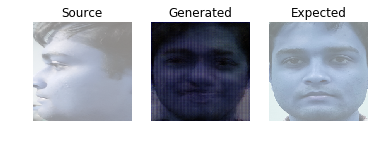

In [188]:
# plot all three images
plot_images(src_image, gen_image, tar_image)

In [127]:
data = load('cfaces_256.npz')
# unpack arrays
X1, X2 = data['arr_0'], data['arr_1']
# scale from [0,255] to [-1,1]
X1 = (X1 - 127.5) / 127.5
X2 = (X2 - 127.5) / 127.5


In [131]:
X1[1].shape

(256, 256, 3)

In [144]:
import numpy as np
import argparse
import cv2
import os
import tqdm


# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe('deploy.prototxt.txt', 'res10_300x300_ssd_iter_140000.caffemodel')

[INFO] loading model...


In [145]:
def cropFace(image):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the detections and
    # predictions
    print("[INFO] computing object detections...")
    net.setInput(blob)
    detections = net.forward()
    status = False
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the
        # prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for the
            # object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # draw the bounding box of the face along with the associated
            # probability
            text = "{:.2f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(image, (startX, startY), (endX, endY),
                (0, 0, 255), 2)
            #cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            roi_color = image[startY:endY, startX:endX]
            status = True
            return (status, roi_color)
            break
    return (status,None)

In [179]:

src_image = cv2.imread(r'/home/dai/Documents/Facialization Project/testSet/test02.jpg')
status,src_image = cropFace(src_image)


[INFO] computing object detections...


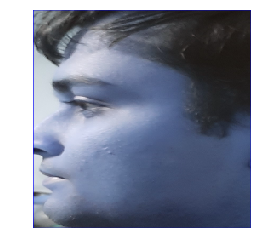

In [180]:
#status,src_image = cropFace(src_image)
src_image = cv2.resize(src_image, (256, 256), interpolation = cv2.INTER_AREA)
#src_image=np.asarray(src_image)
#src_image = np.asarray([src_image])
#src_image.shape
pyplot.imshow(src_image)
pyplot.axis('off')
pyplot.show()

In [181]:
src_image = np.asarray([src_image])
src_image = (src_image - 255) / 255

In [182]:
tar_image = cv2.imread(r'/home/dai/Documents/Facialization Project/testSet/tar01.jpg')
status, tar_image = cropFace(tar_image)

[INFO] computing object detections...


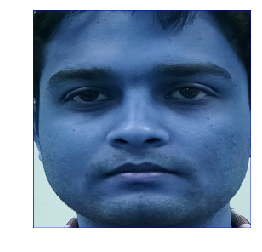

In [183]:
tar_image = cv2.resize(tar_image, (256, 256), interpolation = cv2.INTER_AREA)
#src_image=np.asarray(src_image)
#src_image = np.asarray([src_image])
#src_image.shape
pyplot.imshow(tar_image)
pyplot.axis('off')
pyplot.show()

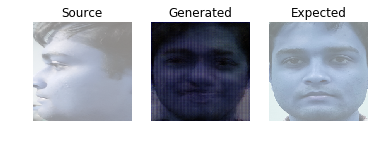

In [184]:
tar_image = np.asarray([tar_image])
tar_image = (tar_image - 255) / 255
gen_image = model.predict(src_image)


#status, src_image = cropFace(src_image)
#src_image = np.asarray(src_image)
#print('Loaded', src_image.shape)
plot_images(src_image, gen_image, tar_image)

## Our model demonstration ends here .... rest of the code were just for testing purposes during development

In [141]:
gen_image.shape

(1, 256, 256, 3)

In [101]:
src_image = np.asarray([src_image])
src_image.shape

(1, 256, 256, 3)

In [102]:
# generate image from source
gen_image = model.predict(src_image)
gen_image = (gen_image + 1) / 2.0
cv2.imshow("image", gen_image[0])
cv2.waitKey(1000)
cv2.destroyAllWindows()

In [79]:
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

In [64]:
model = tf.keras.models.load_model('model_009500.h5', compile = False)
#opt = Adam(lr=0.0002, beta_1=0.5)
#model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt)

In [80]:
[X1, X2] = load_real_samples('cfaces_256.npz')
print('Loaded', X1.shape, X2.shape)

# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]


# plot all three images
plot_images(src_image, gen_image, tar_image)

Loaded (95, 256, 256, 3) (95, 256, 256, 3)


In [66]:
gen_image.shape

(1, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


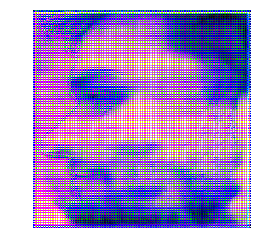

In [56]:

pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()

In [70]:
# load model
model = tf.keras.models.load_model('model_009500.h5', compile=False)
# generate image from source

gen_image = model.predict(src_image, steps=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


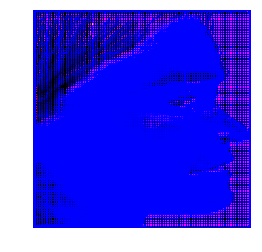

In [71]:
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()

In [30]:
src = np.asarray(src)
tgt = np.asarray(tgt)

In [18]:
Ffilename = 'cfaces_256.npz'
savez_compressed(filename, src, tgt)
print('Saved dataset: ', filename)

NameError: name 'filename' is not defined

In [29]:
d = './testDataset'
lst = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]

src = []
tgt = []
P = []
for path in tqdm(lst):
    path1 = path +"/sideviews/*.jpg"
    
    for file in glob.glob(path1):
        #print (file)
        a= cv2.imread(file)
        a= cv2.resize(a, (256,256), interpolation = cv2.INTER_AREA)
        file = file.split('/')
        file = (file[len(file) - 1])
        file = file.split('_')
        ylabel = (file[0])
        pose_label = (file[len(file) - 1]).split('.')[0]
        if pose_label in ['01','02','04','05']:
            path2 = path+"/"+ylabel+"_03.jpg"
        elif pose_label in ['066','07','09','10']:
            path2 = path+"/"+ylabel+"_08.jpg"
        #print(path2)
        #print('___________________________')
        b= cv2.imread(path2)
        b= cv2.resize(b, (256,256), interpolation = cv2.INTER_AREA)
        src.append(a)
        tgt.append(b)

100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


In [4]:
# load an image
def load_image(filename, size=(256,256)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = tf.keras.preprocessing.image.img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = tf.keras.backend.expand_dims(pixels, 0)
	return pixels

In [69]:
src_image = np.asarray([src_image])
src_image.shape

(1, 256, 256, 3)

In [65]:
gen_image = model.predict(src_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


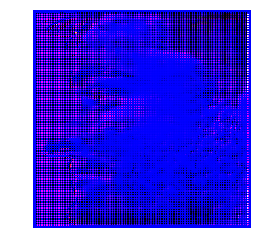

In [64]:
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
# plot the image
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()